# Purpose:
- Test online motion correction results.
- Confirm correction by estimating FOV depth across time, and comparing with the log. (as before, 241106_omc_test_analysis.ipynb)
- In addition, check fluorescence change related to motion correction.
- First, split the file and run suite2p for each plane. (ref 240515_off_pipeline_splitting.ipynb)
## Use suite2p env

In [2]:
from pathlib import Path
import tifffile
from tifffile import read_scanimage_metadata
import json
import h5py
import time
from suite2p import default_ops
from suite2p.registration import nonrigid, register
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import suite2p

In [3]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_746542\1406178882')
data_fn = data_dir / '1406178882_timeseries_00003.tif'

# Load motion data
motion_fn = data_dir / '1406178882_timeseries_Motion_00003.csv'
motion_df = pd.read_csv(motion_fn)
# Clean up column names
motion_df['dx'] = motion_df[' drPixel'].apply(lambda x: x.split('[')[1].split(']')[0].split(' ')[0])
motion_df['dy'] = motion_df[' drPixel'].apply(lambda x: x.split('[')[1].split(']')[0].split(' ')[1])
motion_df['dz'] = motion_df[' drPixel'].apply(lambda x: x.split('[')[1].split(']')[0].split(' ')[2])

# Load motion correction data
correction_fn = data_dir / '1406178882_timeseries_Motion_Corrected_00003.csv'
correction_df = pd.read_csv(correction_fn)
# Clean up column names
correction_df['dx'] = correction_df[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
correction_df['dy'] = correction_df[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
correction_df['dz1'] = correction_df[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
correction_df['dz2'] = correction_df[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[3]))

In [75]:
with open(data_fn, 'rb') as fh:
    md_dict, roi_groups, num_roi_groups = read_scanimage_metadata(fh)
assert len(roi_groups['RoiGroups']['imagingRoiGroup']['rois']['scanfields']) / 2 == num_roi_groups
frame_rate = md_dict['SI.hRoiManager.scanFrameRate']
volume_rate = md_dict['SI.hRoiManager.scanVolumeRate']

Text(0.5, 1.0, 'Channel 1 Motion in z')

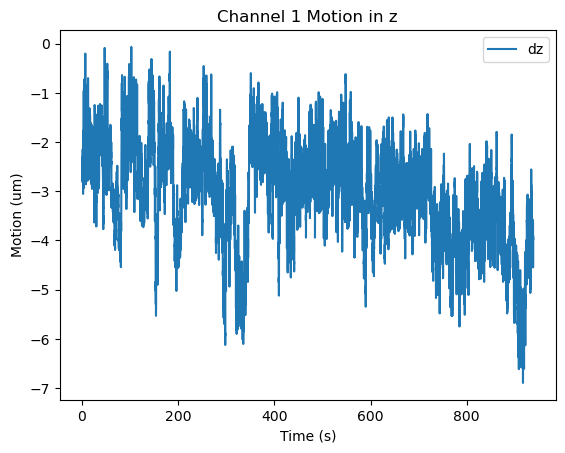

In [62]:
# First channel motion
fig, ax = plt.subplots()
motion_df.iloc[::2][['dz']].rolling(10).mean().plot(y='dz', ax=ax, color='C0')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Motion (um)')
ax.set_title('Channel 1 Motion in z')

Text(0.5, 1.0, 'Channel 2 Motion in z')

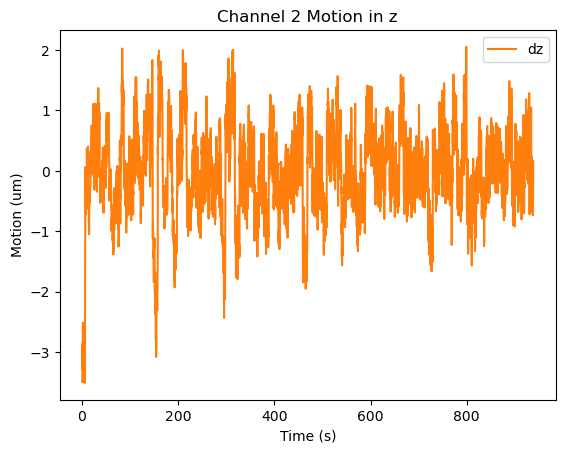

In [64]:
# Second channel motion
fig, ax = plt.subplots()
motion_df.iloc[1::2][['dz']].rolling(10).mean().plot(y='dz', ax=ax, color='C1')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Motion (um)')
ax.set_title('Channel 2 Motion in z')

Text(0.5, 1.0, 'Channel 1 Correction')

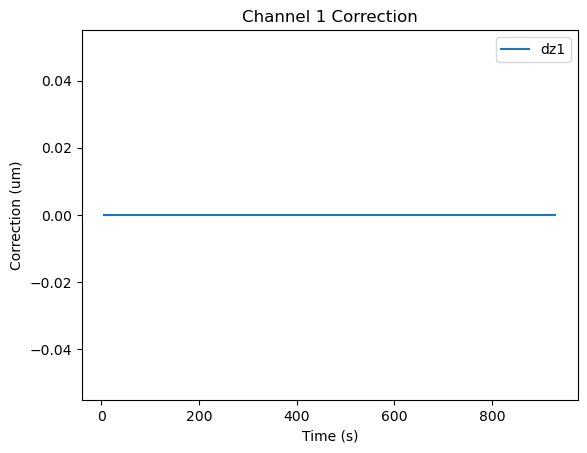

In [65]:
# first channel correction
fig, ax = plt.subplots()
correction_df.plot(x='timestamp', y='dz1', ax=ax, color='C0')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Correction (um)')
ax.set_title('Channel 1 Correction')

Text(0.5, 1.0, 'Channel 2 Correction')

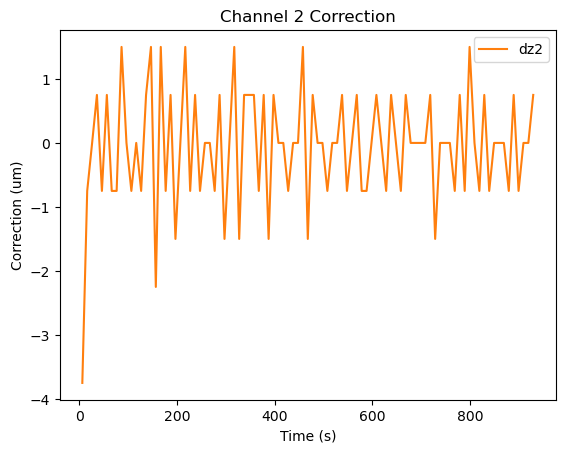

In [ ]:
# second channel correction
fig, ax = plt.subplots()
correction_df.plot(x='timestamp', y='dz2', ax=ax, color='C1')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Correction (um)')
ax.set_title('Channel 2 Correction')

## Further analysis on Ch2 (upper planes)

In [67]:
# Split the file into 8 planes
num_planes = 8

with tifffile.TiffFile(data_fn) as tif:
# with Image.open(data_fn) as img:
    # frames.append(tif.pages[fnum].asarray())
    num_pages = (len(tif.pages))
    # dtype = tif.pages[0].asarray().dtype
    for i in range(num_planes):
        print(f'processing {i}/{num_planes-1}')
        temp_imgs = [tif.pages[ii].asarray() for ii in range(i,num_pages,num_planes)]
        temp_name = data_fn.name.split('.')[0]
        temp_fn = data_fn.parent / f'{temp_name}_{i:02}.h5'
        # tifffile.imwrite(temp_fn, temp_imgs)
        with h5py.File(temp_fn, 'w') as h:
            h.create_dataset('data', data=temp_imgs)
        # with tifffile.TiffWriter(temp_fn, bigtiff=True) as tif:
        #     for image in temp_imgs:
        #         tif.write(image)

processing 0/7
processing 1/7
processing 2/7
processing 3/7
processing 4/7
processing 5/7
processing 6/7
processing 7/7


In [86]:
# run suite2p for each planes
# About an hour for 8 planes, about 1000 seconds of data
base_name = data_fn.name.split('.')[0]
for i in range(1, num_planes):
    block_size = 64
    ops=default_ops()
    ops['batch_size'] = 1000
    ops['maxregshift'] = 0.2
    ops['snr_thresh'] = 1.2 # Default: 1.2 # if any nonrigid block is below this threshold, it gets smoothed until above this threshold. 1.0 results in no smoothing
    ops['block_size'] = [block_size, block_size] # block size to register (default [128, 128])
    ops['maxregshiftNR'] = np.round(block_size/10) # Default = 5
    ops['do_bidiphase'] = True

    fn = data_fn.parent / f'{base_name}_{i:02}.h5'
    ops['h5py'] = str(fn)
    ops['fast_disk'] = r'C:\\'
    ops['keep_movie_raw'] = False
    ops['save_path0'] = str(data_dir / f'{base_name}_{i:02}')

    output_ops = suite2p.run_s2p(ops=ops, db={})

{}
h5
OPS1 h5py: \\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_746542\1406178882\1406178882_timeseries_00003_01.h5
time 62.27 sec. Wrote 8894 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying default C:\Users\jinho.kim\.suite2p\classifiers\classifier_user.npy
----------- REGISTRATION
NOTE: estimated bidiphase offset from data: -1 pixels
Reference frame, 15.43 sec.
Registered 1000/8894 in 36.21s
Registered 2000/8894 in 70.15s
Registered 3000/8894 in 103.88s
Registered 4000/8894 in 136.98s
Registered 5000/8894 in 170.77s
Registered 6000/8894 in 204.57s
Registered 7000/8894 in 238.16s
Registered 8000/8894 in 270.85s
Registered 8894/8894 in 299.00s
----------- Total 327.56 sec
Registration metrics, 31.03 sec.
----------- ROI DETECTION
Binning movie in chunks of length 10
Binned movie of size [8

In [87]:
correction_df

,timestamp,dr,dx,dy,dz1,dz2
0,6.223261,[-0.0297106087790842 -0.0385008022154844 0 -3...,-0.029711,-0.038501,0.0,-3.75
1,16.217539,[-0.00335699249710072 0.00162760416689853 0 -...,-0.003357,0.001628,0.0,-0.75
2,26.291074,[-0.00277550334193197 0.00415618666822396 0 0],-0.002776,0.004156,0.0,0.00
3,36.101019,[0.00298486097941453 -0.00275867394985137 0 0...,0.002985,-0.002759,0.0,0.75
4,46.359370,[0.00106967616064265 0.00288388462693096 0 -0...,0.001070,0.002884,0.0,-0.75
...,...,...,...,...,...,...
88,889.624261,[0.00951116459313299 0.00571687717221013 0 0.75],0.009511,0.005717,0.0,0.75
89,899.645981,[-0.0125439556811928 -0.00892025097839909 0 -...,-0.012544,-0.008920,0.0,-0.75
90,909.641330,[-0.0132630419460127 0.0087769991930091 0 0],-0.013263,0.008777,0.0,0.00
91,919.663053,[0.00942634445704674 0.00523905707225791 0 0],0.009426,0.005239,0.0,0.00


In [39]:
F = []
spk = []
for plane_i in range(8):
    plane_name = data_fn.name.split('.')[0] + '_' + str(plane_i).zfill(2)
    plane_dir = data_dir / plane_name / 'suite2p/plane0'
    iscell = np.load(plane_dir / 'iscell.npy')
    iscell_ind = np.where(iscell[:,0])[0]
    F_plane = np.load(plane_dir / 'F.npy')
    spk_plane = np.load(plane_dir / 'spks.npy')    
    F.append(F_plane[iscell_ind, :])
    spk.append(spk_plane[iscell_ind, :])


In [54]:
total_frame_nums = int(np.sum([f.shape[1] for f in F]) / 2)
estimated_timestamps = np.arange(0, total_frame_nums) / frame_rate
correction_timestamps = correction_df['timestamp'].values

In [51]:
np.max([np.min(np.abs(estimated_timestamps - t)) for t in correction_timestamps])

0.013055610101901038

In [56]:
np.max(np.diff(estimated_timestamps))

0.026378333891784678

### minimum difference from correction timestamp to estimated timestamps (0.013) are less than half of the frame period (0.026)
- I can safely use the frame with minimum difference as correction frame.

In [78]:
correction_frames_tif = [np.argmin(np.abs(estimated_timestamps - t)) for t in correction_timestamps]
correction_frames_each = [f // num_roi_groups for f in correction_frames_tif]

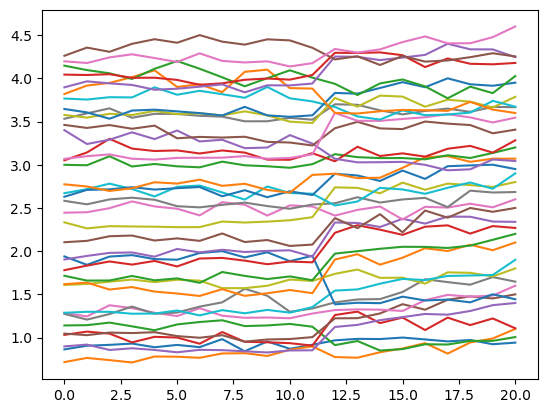

In [106]:
fig, ax = plt.subplots()
center_frame = correction_frames_each[0]
temp_mat = F[3][:, center_frame - 10 : center_frame + 11]
temp_mat = temp_mat / np.max(temp_mat, axis=1)[:, None]
for i in range(temp_mat.shape[0]):
    ax.plot(temp_mat[i, :] + i * 0.1)


In [112]:
large_change_inds = np.where(np.abs(correction_df.dz2.values) > 1)[0]

In [125]:
np.abs(correction_df.dz2.values)[large_change_inds]

array([3.75, 1.5 , 1.5 , 2.25, 1.5 , 1.5 , 1.5 , 1.5 , 1.5 , 1.5 , 1.5 ,
       1.5 , 1.5 , 1.5 , 1.5 ])

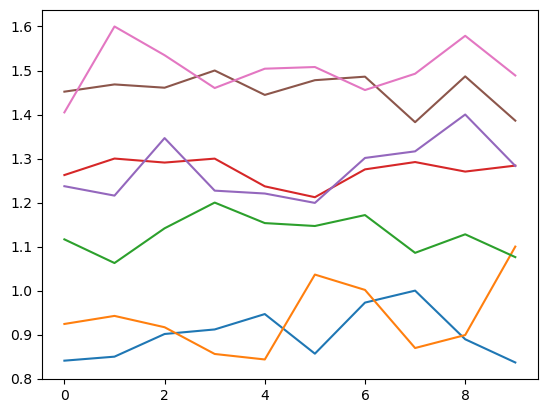

In [137]:
fig, ax = plt.subplots()
ind = large_change_inds[3]
center_frame = correction_frames_each[ind]
temp_mat = F[4][:, center_frame - 5 : center_frame + 5]
temp_mat = temp_mat / np.max(temp_mat, axis=1)[:, None]
for i in range(temp_mat.shape[0]):
    ax.plot(temp_mat[i, :] + i * 0.1)